In [101]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import warnings
import datetime
from sklearn import preprocessing
warnings.filterwarnings("ignore")
%matplotlib inline

In [129]:
features = pd.read_csv('temps.csv')

#看看数据长什么样子
features.head()

,year,month,day,week,temp_2,temp_1,average,actual,friend
0,2016,1,1,Fri,45,45,45.6,45,29
1,2016,1,2,Sat,44,45,45.7,44,61
2,2016,1,3,Sun,45,44,45.8,41,56
3,2016,1,4,Mon,44,41,45.9,40,53
4,2016,1,5,Tues,41,40,46.0,44,41


数据表中
* year,moth,day,week分别表示的具体的时间
* temp_2：前天的最高温度值
* temp_1：昨天的最高温度值
* average：在历史中，每年这一天的平均最高温度值
* actual：这就是我们的标签值了，当天的真实最高温度
* friend：这一列可能是凑热闹的，你的朋友猜测的可能值，咱们不管它就好了

In [130]:
import datetime

In [131]:
years = features['year']
months = features['month']
days = features['day']

dates = [str(int(year))+'-'+str(int(month))+'-'+str(int(day)) for year,month,day in zip(years,months,days)]
dates = [datetime.datetime.strptime(date,'%Y-%m-%d') for date in dates]

#### 1.zip函数能够将多个list结合，按照顺序一一对应
#### 2.datetime.datetime.strptime(date,'%Y-%m-%d') 将时间转化为datetime的格式

In [132]:
dates[:5]

[datetime.datetime(2016, 1, 1, 0, 0),
 datetime.datetime(2016, 1, 2, 0, 0),
 datetime.datetime(2016, 1, 3, 0, 0),
 datetime.datetime(2016, 1, 4, 0, 0),
 datetime.datetime(2016, 1, 5, 0, 0)]

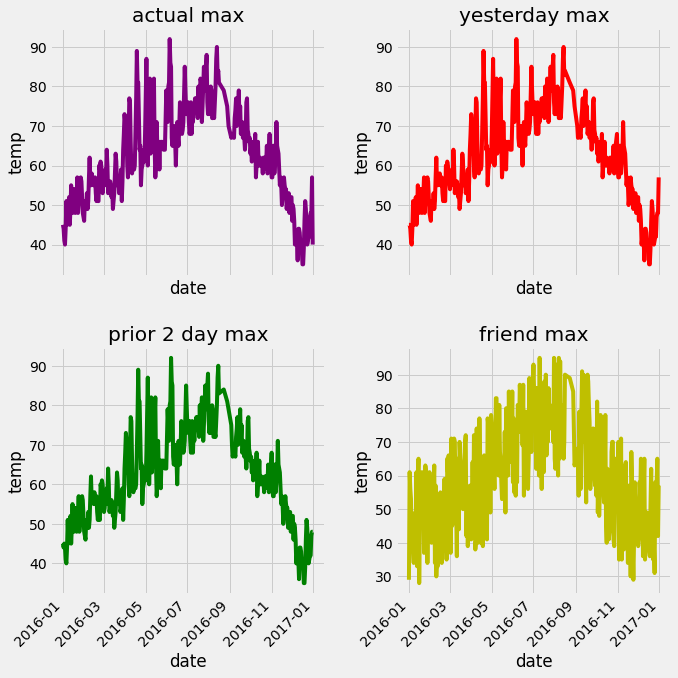

In [133]:
plt.style.use('fivethirtyeight')#定义风格

fig,((ax1,ax2),(ax3,ax4))=plt.subplots(nrows=2,ncols=2,figsize=(10,10))
fig.autofmt_xdate(rotation=45)#x轴倾斜45度

#actual
ax1.plot(dates,features['actual'],color='purple')
ax1.set_xlabel('date')
ax1.set_ylabel('temp')
ax1.set_title('actual max')

#yesterday
ax2.plot(dates,features['temp_1'],color='r')
ax2.set_xlabel('date')
ax2.set_ylabel('temp')
ax2.set_title('yesterday max')

#prior 2 day
ax3.plot(dates,features['temp_2'],color='g')
ax3.set_xlabel('date')
ax3.set_ylabel('temp')
ax3.set_title('prior 2 day max')

#friend
ax4.plot(dates,features['friend'],color='y')
ax4.set_xlabel('date')
ax4.set_ylabel('temp')
ax4.set_title('friend max')

plt.tight_layout(pad=2)

In [134]:
df=pd.get_dummies(features)
df.head()

,year,month,day,temp_2,temp_1,average,actual,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,29,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,44,61,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,41,56,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,40,53,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,44,41,0,0,0,0,0,1,0


In [135]:
labels=df['actual']

features=df.drop(['actual'],axis=1)

feature_list=list(features.columns)

features = np.array(features)

In [136]:
features.shape

(348, 14)

In [137]:
from sklearn import preprocessing
input_features = preprocessing.StandardScaler().fit_transform(features)

In [138]:
labels=np.array(labels)

#### 对数据进行标准化处理

In [139]:
input_features[0]

array([ 0.        , -1.5678393 , -1.65682171, -1.48452388, -1.49443549,
       -1.3470703 , -1.98891668,  2.44131112, -0.40482045, -0.40961596,
       -0.40482045, -0.40482045, -0.41913682, -0.40482045])

# 构建神经网络模型

In [140]:
x=torch.tensor(input_features,dtype=float)

y=torch.tensor(labels,dtype=float)

In [141]:
weights = torch.randn((14,128),dtype=float,requires_grad = True)
biases = torch.randn(128,dtype=float,requires_grad = True)
weights2 = torch.randn((128,1),dtype=float,requires_grad = True)
biases2 = torch.randn(1,dtype=float,requires_grad = True)

##注意NN的特征处理的机制，这一点决定了weights与biases的维度

learning_rate=0.001
losses = []

for i in range(1000):
    hidden = x.mm(weights)+biases
    hidden=torch.relu(hidden)
    predictions= hidden.mm(weights2)+biases2
    loss = torch.mean((predictions-y)**2)
    losses.append(loss.data.numpy())
    
    if i % 100 == 0:
        print('loss:',loss)
    loss.backward()
    
    weights.data.add_(-learning_rate*weights.grad.data)#weights.grad.data 包含了权重的梯度信息,用于更新weights
    biases.data.add_(-learning_rate * biases.grad.data)
    weights2.data.add_(-learning_rate*weights2.grad.data)
    biases2.data.add_(-learning_rate * biases2.grad.data)
    
    weights.grad.data.zero_()#在下一次迭代前清空梯度信息
    biases.grad.data.zero_()
    weights2.grad.data.zero_()
    biases2.grad.data.zero_()

loss: tensor(8557.6265, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(157.6237, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(147.9178, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(145.0419, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(143.5137, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(142.5368, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(141.8482, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(141.3558, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(140.9832, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(140.6958, dtype=torch.float64, grad_fn=<MeanBackward0>)


#### 1.注意NN的特征处理的机制，这一点决定了weights与biases的维度
#### 2.add_表示inplace=True的计算方式
#### 3.weights.grad表示权重的梯度信息

In [142]:
predictions.shape

torch.Size([348, 1])

### 更简单的构建网络模型

In [143]:
input_size = input_features.shape[1]
hidden_size= 128
output_size= 1
batch_size= 16
my_nn=torch.nn.Sequential(
    torch.nn.Linear(input_size,hidden_size),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden_size,output_size),
    )
cost=torch.nn.MSELoss(reduction='mean')
optimizer=torch.optim.Adam(my_nn.parameters(),lr=0.001)

In [144]:
losses=[]
for i in range(1000):
    batch_loss=[]
    for start in range(0,len(input_features),batch_size):
        end = start+batch_size if start+batch_size < len(input_features) else len(input_features)
        xx=torch.tensor(input_features[start:end],dtype=torch.float,requires_grad=True)
        yy=torch.tensor(labels[start:end],dtype=torch.float,requires_grad=True)
        prediction=my_nn(xx)
        loss=cost(prediction,yy)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        batch_loss.append(loss.data.numpy())
        
    if i % 100==0:#如果i能被100整除
        losses.append(np.mean(batch_loss))
        print(i,np.mean(batch_loss))

0 4030.2126
100 37.84918
200 35.63489
300 35.26941
400 35.10497
500 34.972855
600 34.850822
700 34.727844
800 34.602055
900 34.472202


## 预测训练结果

In [157]:
x = torch.tensor(input_features,dtype=torch.float)
predict=my_nn(x).data.numpy()

In [158]:
predict.reshape(-1).shape

(348,)

In [162]:
dates = [str(int(year))+'-'+str(int(month))+'-'+str(int(day)) for year,month,day in zip(years,months,days)]
dates = [datetime.datetime.strptime(date,'%Y-%m-%d') for date in dates ]
true_date = pd.DataFrame(data={'date':dates,'actual':labels})


In [163]:
months = features[:, feature_list.index('month')]
days = features[:, feature_list.index('day')]
years = features[:, feature_list.index('year')]

test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]

test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predict.reshape(-1)}) 

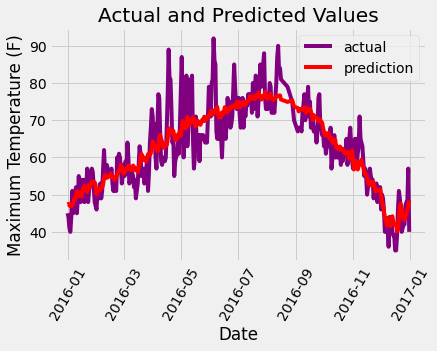

In [166]:
plt.plot(true_date['date'],true_date['actual'],color='purple',label='actual')
plt.plot(predictions_data['date'],predictions_data['prediction'],color='r',label='prediction')
plt.xticks(rotation='60')
plt.legend()

plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');

In [167]:
def RMSLE(x,y):
    x = np.log1p(x)
    y = np.log1p(y)

# 计算均方误差（MSE）
    mse = np.mean(( x- y) ** 2)

# 计算RMSLE
    rmsle = np.sqrt(mse)
    print("RMSLE:", rmsle)
    return rmsle

In [168]:
RMSLE(labels,predict.reshape(-1))

RMSLE: 0.08125812323475597


0.08125812323475597